# Background Subtraction of YMnO3

In a dataset, not only the desired signal but also a lot of background points are often measured, which may initially seem wasteful. However, if we assume that the background from the sample environment, sample holder, and other general background sources is independent of the sample rotation ($A_3$), then removing the regions of reciprocal space with a signal (hereafter denoted as foreground) will enable us to use all the remaining points to approximate the background. However, certain requirements need to be fulfilled. By integrating along A3, we end up with a background intensity that depends on $|Q|$ and energy transfer. Sampling from this intensity gives us a powder-averaged background estimator. This method only works if the following points are true:

- The foreground intensity has a limited extend
- Enough reciprocal space has been measured
    - All $|Q|$ and energy points must have some coverage
- Masks must be possible to create to remove the foreground

In the following example, we will use the data from YMnO3 to demonstrate how the background can be defined and help to subtract it from the signal.

**Warning**:  If we do not remove all the foreground intensity and include it in the background calculation, we will end up over-subtracting the background esulting in negative scattering intensity. Negative intensities are a sign of oversubtraction, but they may also to some extend occur naturally due to counting uncertainties. The error bars for 1D cuts are propagated by estimating the root of errors added in quadrature. 


## Example using YMnO3

In [1]:
%matplotlib inline

from MJOLNIR.Data import DataSet,Mask
from MJOLNIR import _tools # Usefull tools useful across MJOLNIR
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 12]
plt.rcParams['figure.dpi'] = 200

numbers = '136-137' # String of data numbers
fileList = _tools.fileListGenerator(numbers,r'C:\Users\lass_j\Documents\CAMEA2018',2018) # Create file list from 2018 in specified folder

ds = DataSet.DataSet(fileList)
ds.convertDataFile();


To make a background subtraction, first we need to remove the actual signal in the data. This is done by generating suitable masks; notice that the exact centre of the dispersion is a little off.

In [2]:
# Center is a little off...
center = np.array([1.011,0.073])
centerHKL = np.array([*center,0.0])
radiusPoint = np.array([1.112,0.057])

# Calculate to Qx Qy instead of HKL as data is from YMnO3, i.e. a hexagonal lattice
centerQxQy = ds[0].sample.calculateHKLToQxQy(*center,0)
radiusPointQxQy = ds[0].sample.calculateHKLToQxQy(*radiusPoint,0)
BGMask = Mask.circleMask(centerQxQy,radiusPointQxQy,coordinates=['qx','qy'])

First the centre is found from the a <code>View3D</code> object (not shown), and then calcualted into ($Q_x$,$Q_y$) through the conversion on the <code>samplde</code> object found in any of the <code>DataFile</code>s. This is done in order to make a circle in ($Q_x$,$Q_y$) space and not in ($H$,$K$) space as the latter is skewed due to the sample having a hexagonal symmetry in the current ($H$,$K$,$0$) scattering plane. 

In [3]:
# Generate background estimation from powder calculation
# by only using data outside the background mask combined with the foreground mask.
# Either provide the mask as a masking object or as a list of boolean arrays of size [df.I.shape for df in ds]

ds.generateBackgroundModel(backgroundMask = BGMask, dQ = 0.025, dE = 0.05,
                       combineForegroundMask = True)

What this does is that it applies the mask to the data and performs a powder average, i.e. calculates $|Q|$ for all data points and performes a binning of the intensities in the provided bin sizes. For the best result one should use bin sizes large enough to contain multiple pixels from the instrument but small enough as to not smear out background features. Thus, choosing the correct binning is quite difficult and some itteration is needed.

Notice the additional flag of combining with the foreground mask. If the <code>DataFile</code>s have any masking, either due to spurios features (Currat-Axe) or non-functioning detector tubes, we would want this parts of the data to also be masked out in the background. If this is not performed, these unwanted features might skew up the powder-averaged background and thus render the background unuseful.

By running the above code a <code>BackgroundModel</code> object is created and attached to the <code>DataSet</code>. The found intensities are plotted by

In [4]:
ax = ds.backgroundModel.plotPowderAverage()
ax.get_figure()
ax.set_clim(0,0.01)

This is all good and great, but unless we invoke the background subtraction for specific cuts, we haven't actually utilized it! Let's perform a QE plot

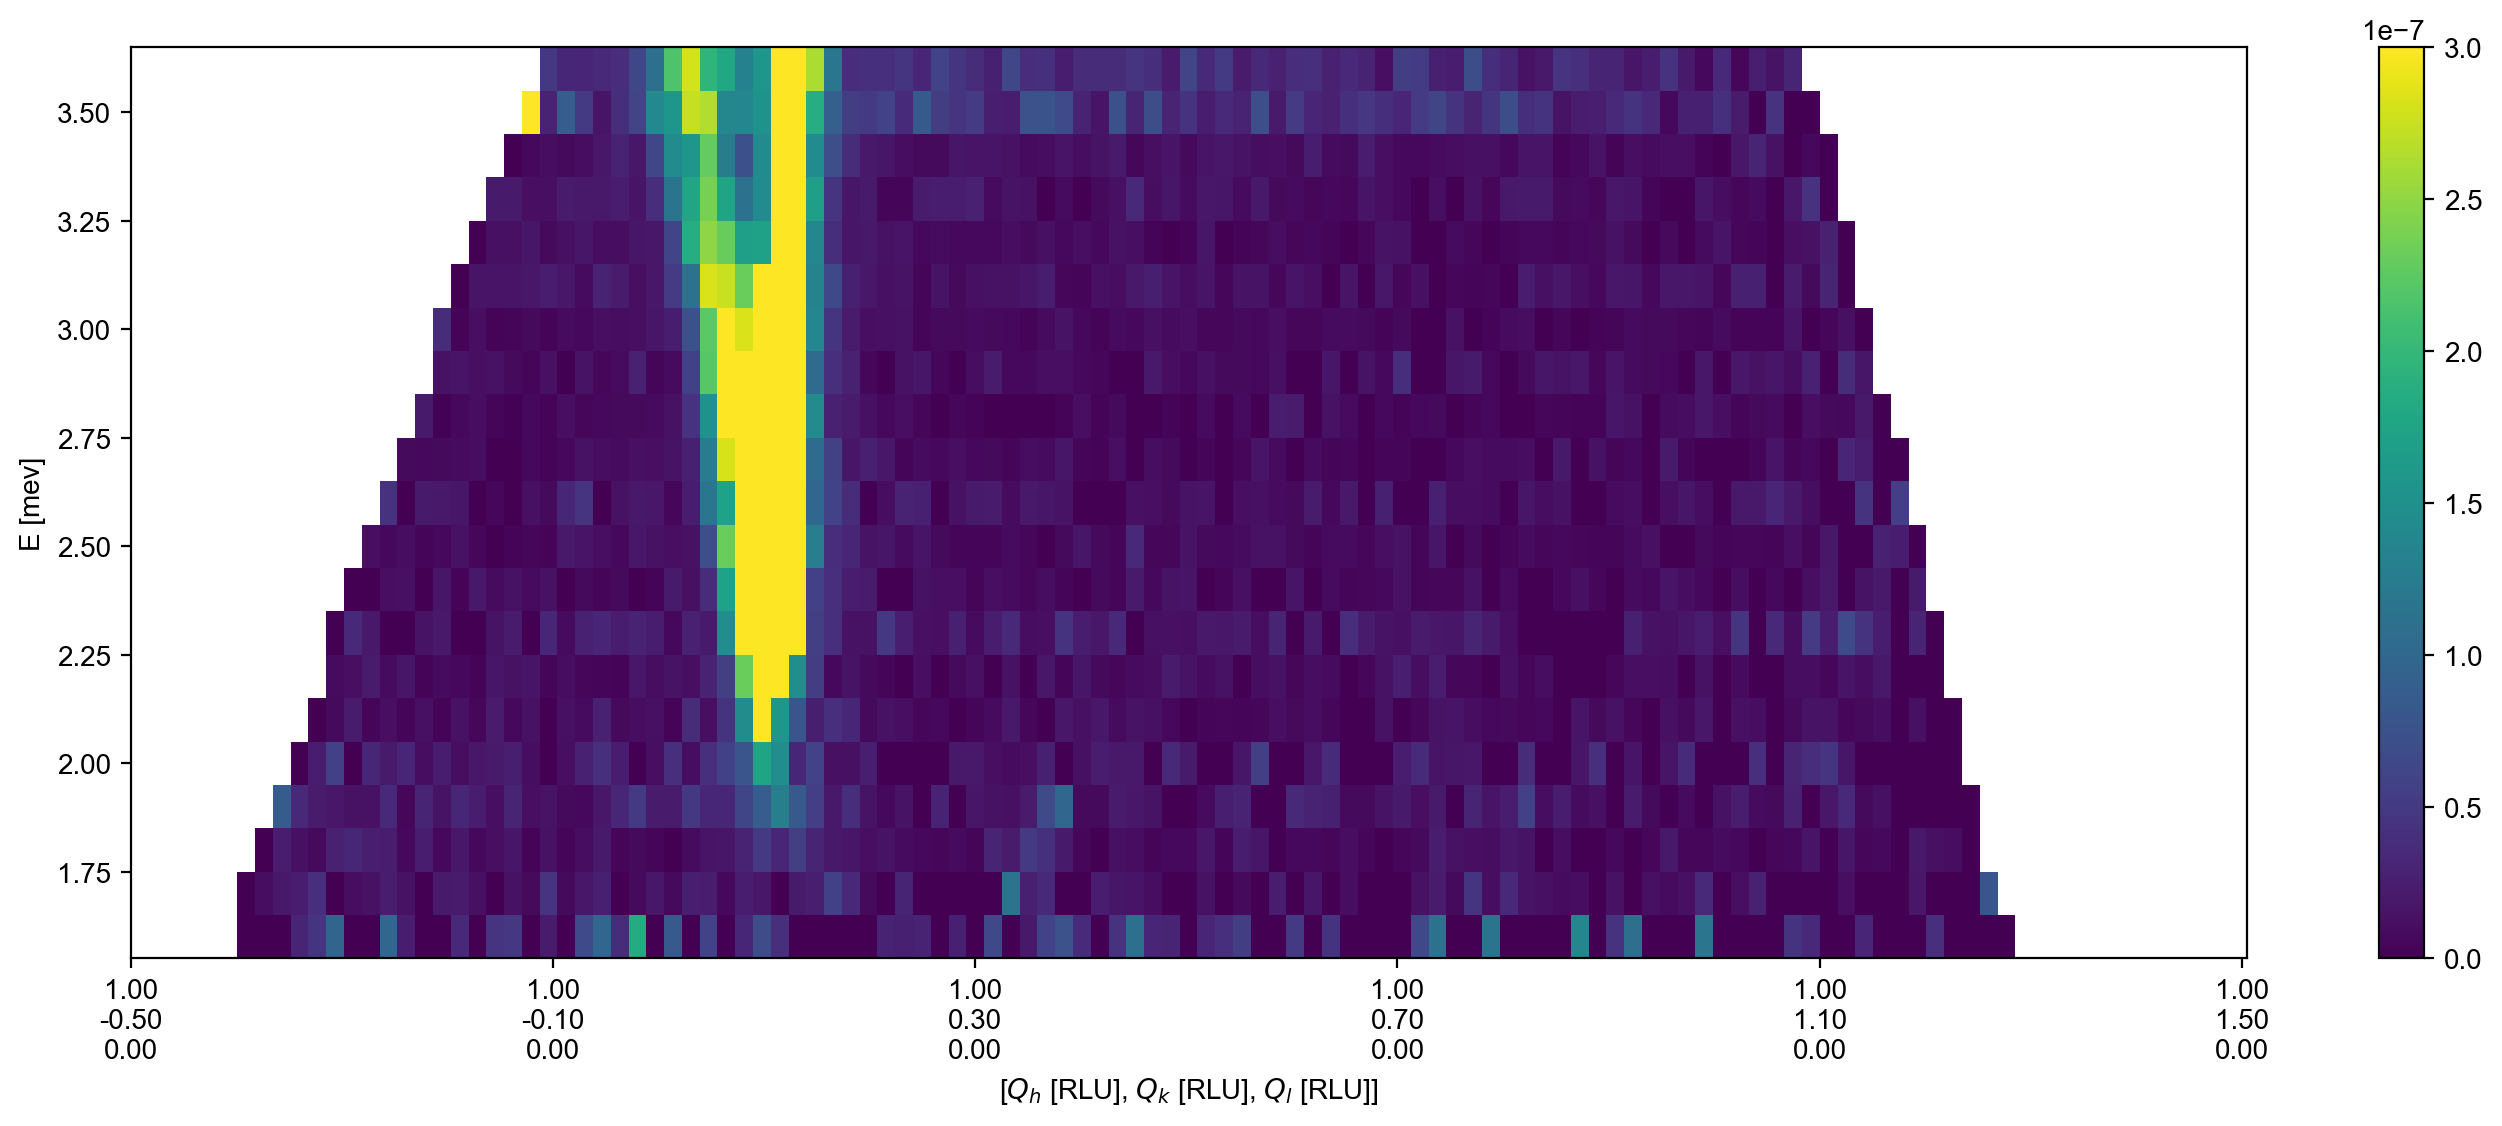

In [5]:
Q1 = np.array([1.0,-0.5,0])
Q2 = np.array([1.0,1.5,0])
EMin = 1.6
EMax = 3.7
dE = 0.1

width = 0.05
minPixel = 0.02

# First the full data is plotted
ax,*_data = ds.plotCutQE(q1 = Q1, q2 = Q2, EMin = EMin, EMax = EMax, dE = dE,
                     width = width, minPixel = minPixel, colorbar = True)
ax.set_clim(0,3e-7)
ax.get_figure()

The above figure is the regular cut *not* using the background subtraction. If one adds the <code>backgroundSubtraction=True</code>

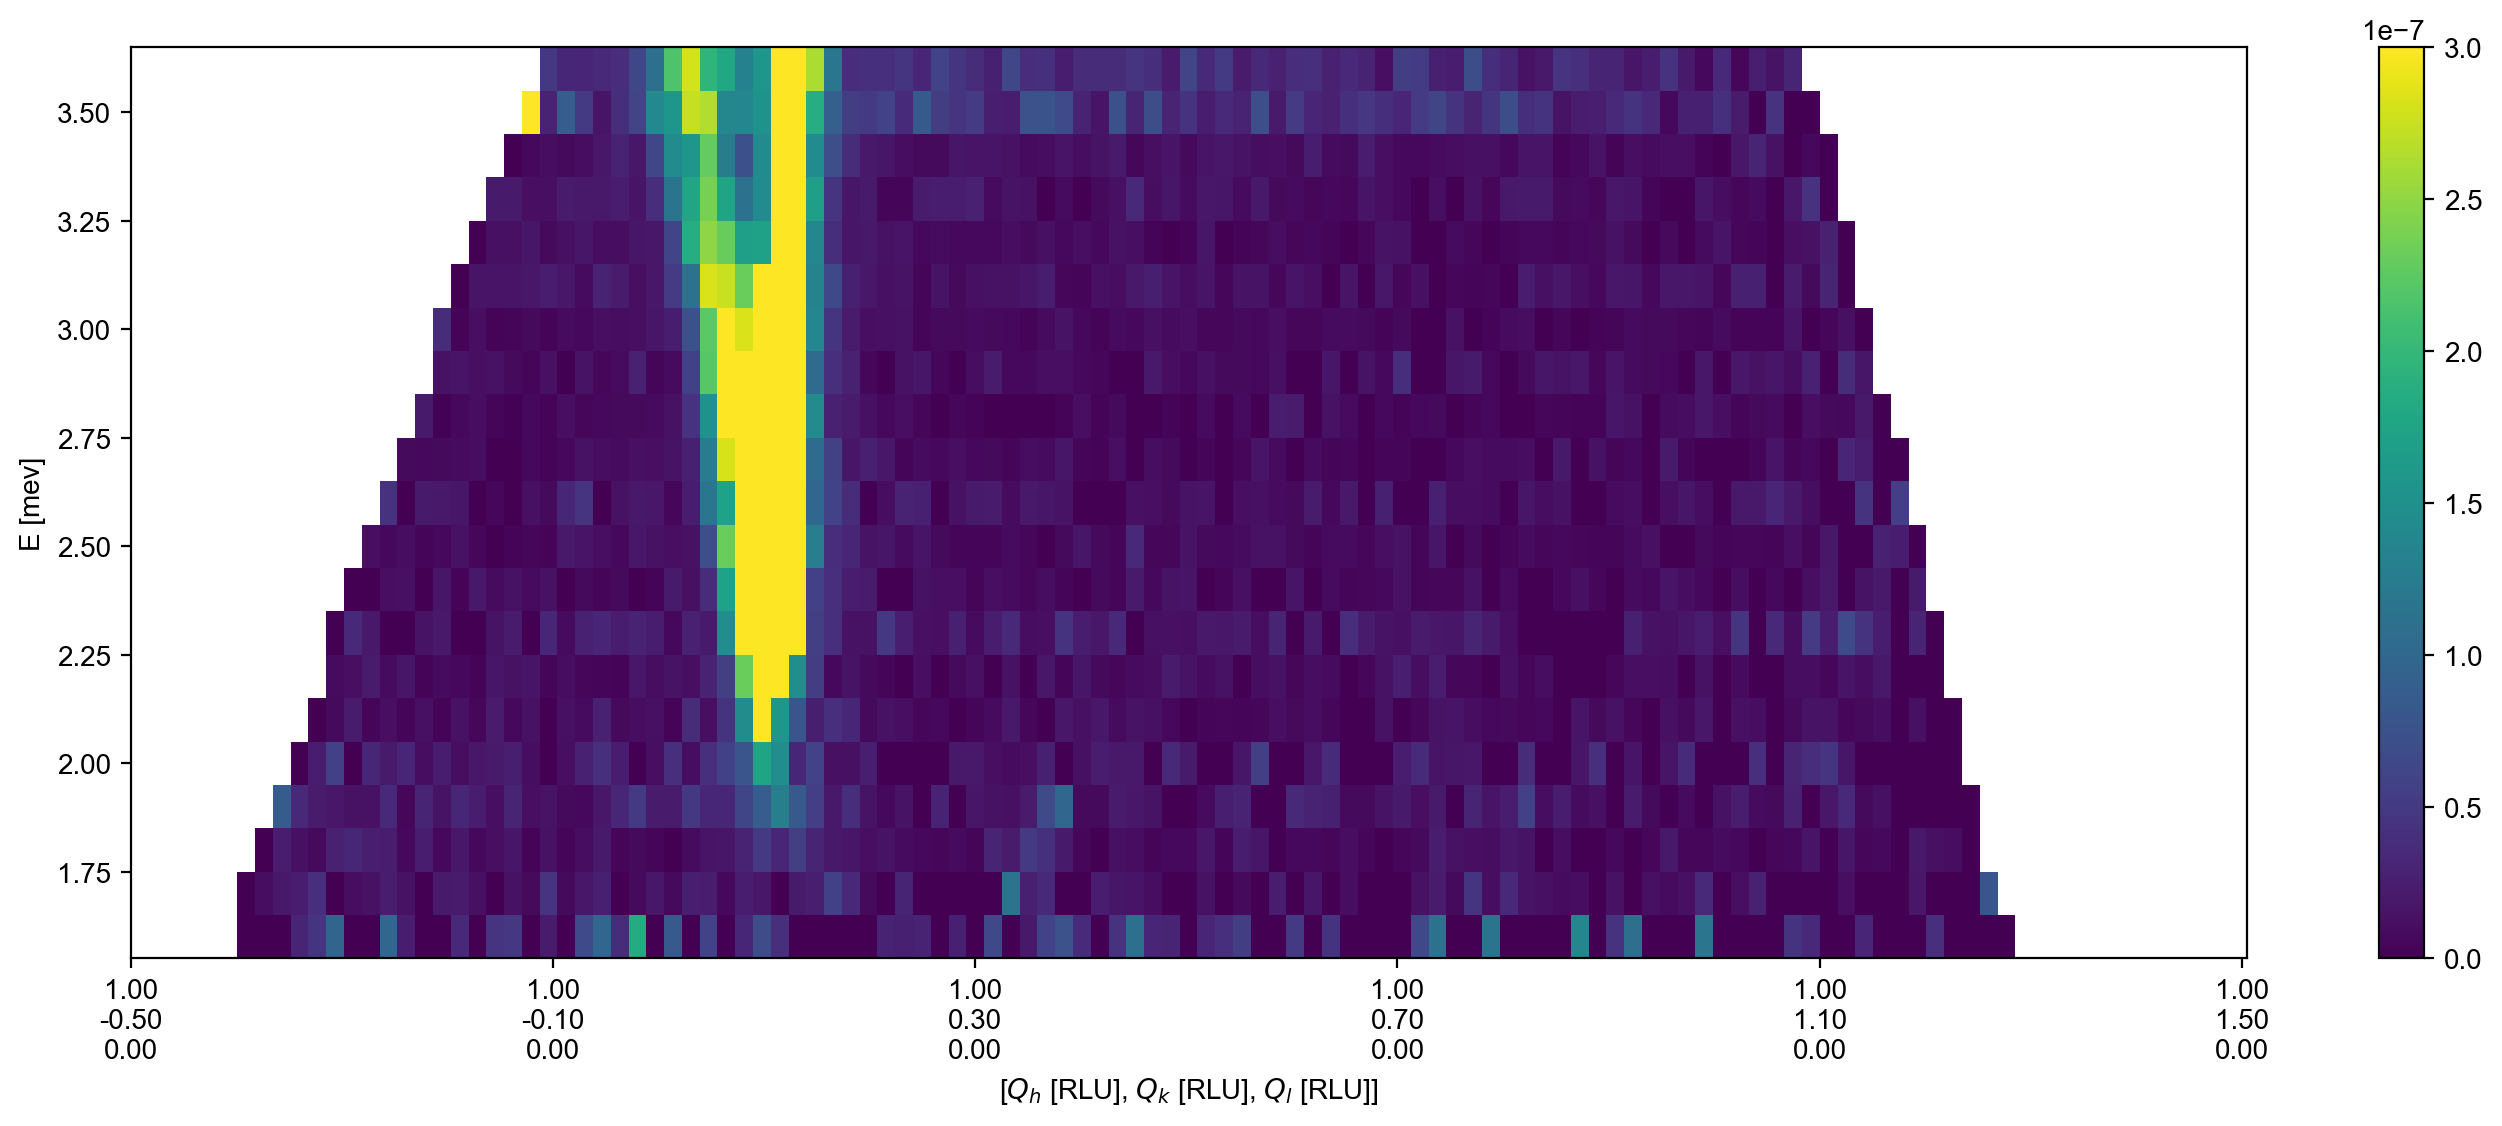

In [6]:
axSub,_dataSub, bins = ds.plotCutQE(q1 = Q1, q2 = Q2, EMin = EMin, EMax = EMax, dE = dE,
                     width = width, minPixel = minPixel,
                     backgroundSubtraction=True, colorbar = True)


axSub.set_clim(0,3e-7)
ax.get_figure()

Some difference between the two above figures is visible but unless one is to do 1D cuts it is not too different. The background subtraction has been implemented for all of the cutting functions. For the <code>plotCut1D</code> and <code>plotCut1DE</code> two additional keyword arguments have been added allowing for a direct plotting of the also the unsubtracted and the background signal with correct errorbars

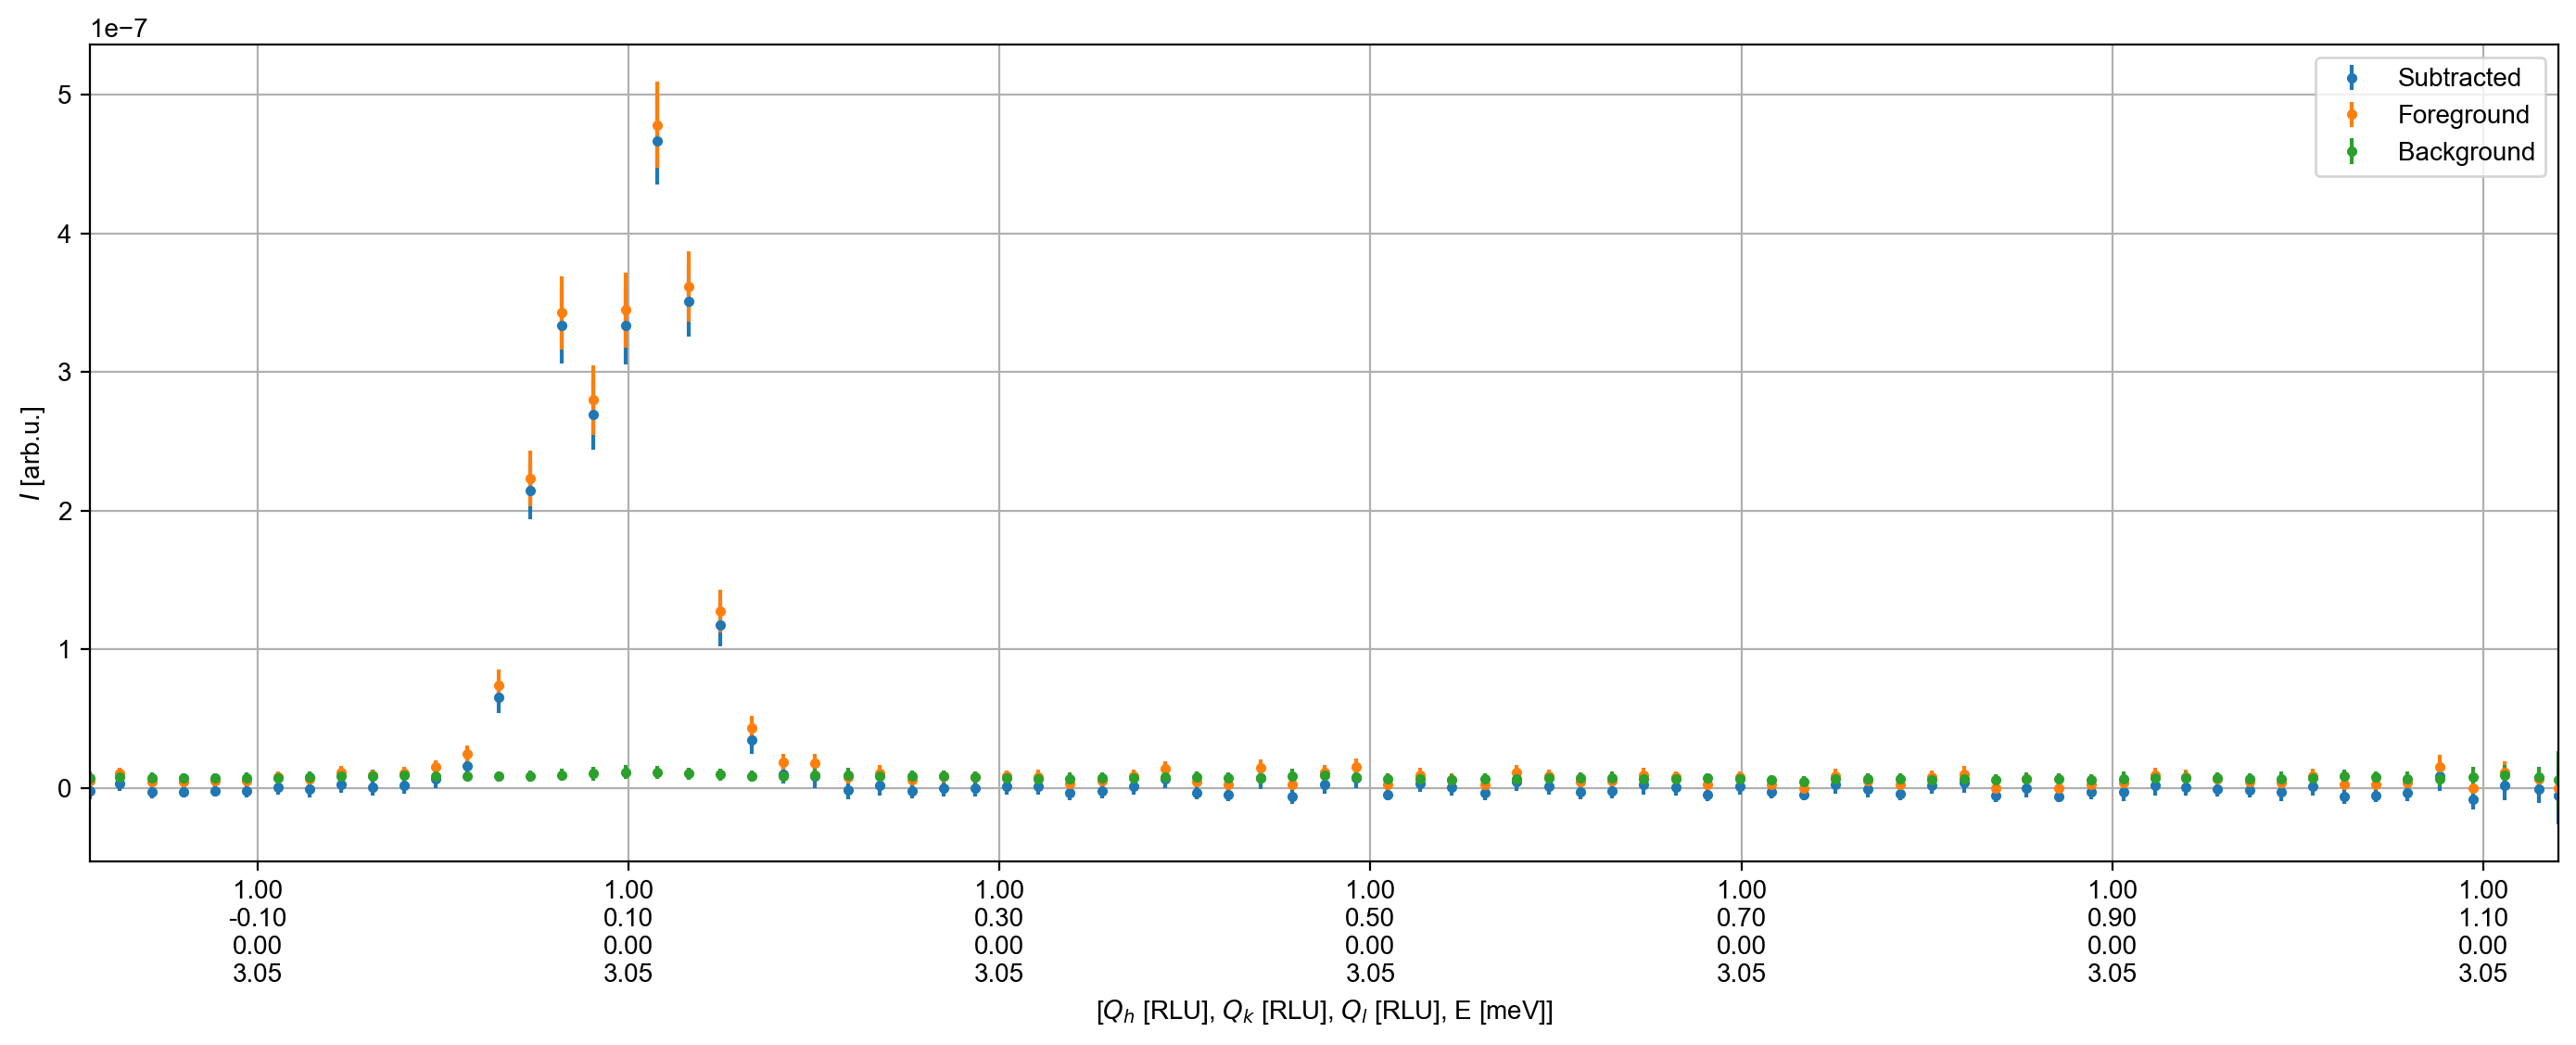

In [7]:
Emin1D = 3.0
Emax1D = 3.1

# Either plot using two different calls, and a third for the background
ax1D,data1Dsub,bins = ds.plotCut1D(q1 = Q1, q2 = Q2, width = width, minPixel = minPixel,
                             Emin = Emin1D, Emax = Emax1D, backgroundSubtraction = True,
                             label = 'Subtracted', plotForeground=True, plotBackground=True)
ax1D.grid(True)
ax1D.legend()
ax1D.get_figure()

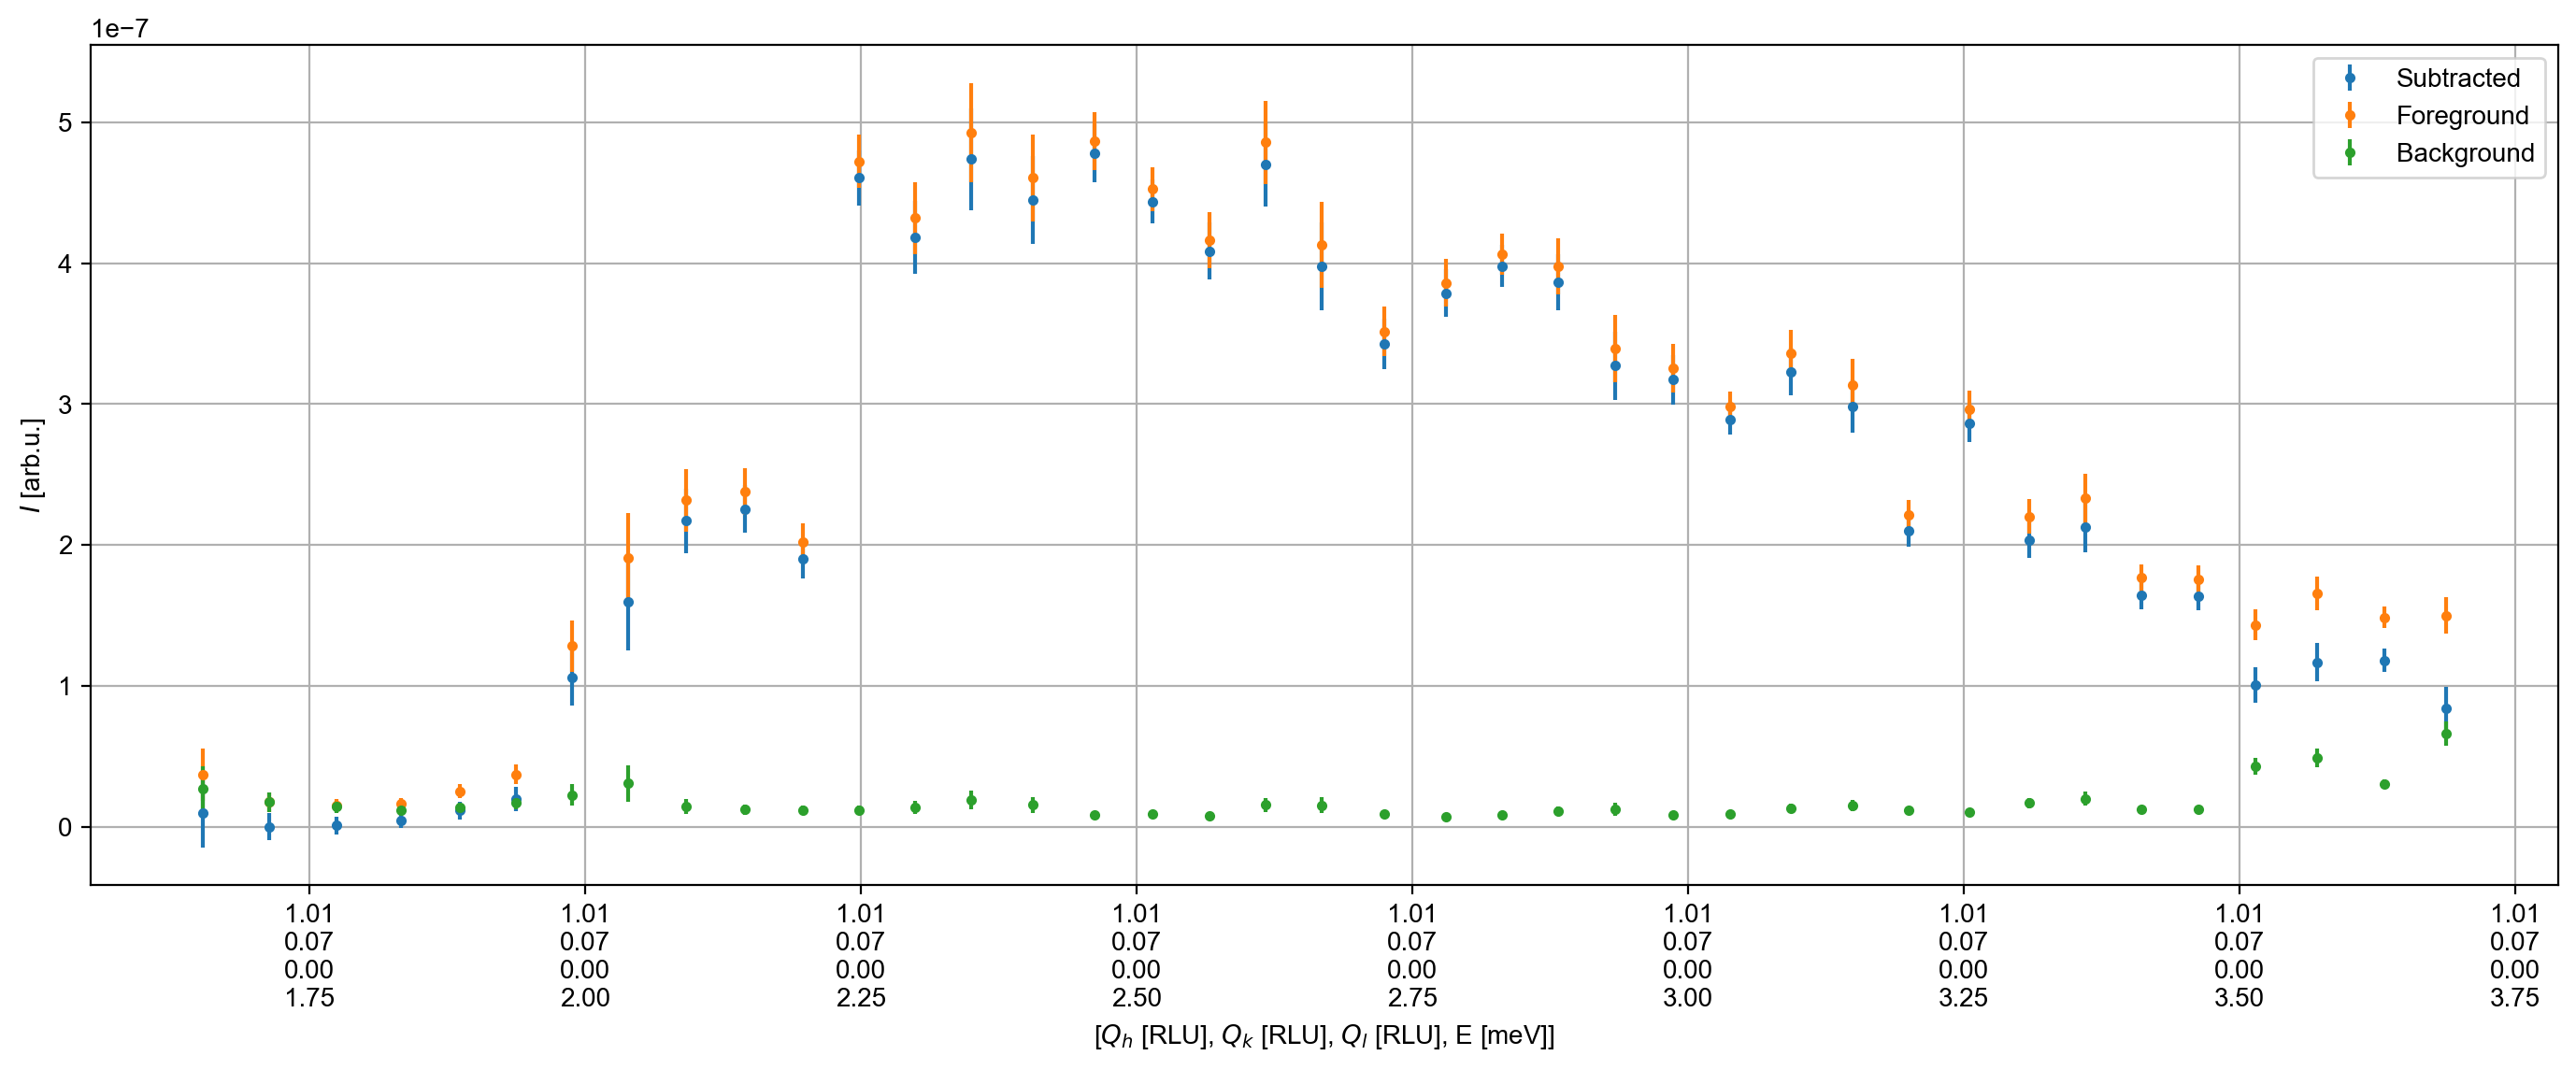

In [8]:
ax1DE,data1DEsub,binsE = ds.plotCut1DE(q = centerHKL, width = width, minPixel = 0.05,
                             E1 = EMin, E2 = EMax, backgroundSubtraction = True,
                             label = 'Subtracted', plotForeground=True, plotBackground=True)
ax1DE.grid(True)
ax1DE.legend()
ax1DE.get_figure()

Not Too much of a difference can be seen but the subtracted data follows the zero line neatly. Far more important is the background subtraction when performing energy cuts due to the presence of the constant energy stripes (To experimentally remove these see FAQ). A cut through the dispersion at HKL = (1.0,0.0,0.0) is performed and plotted similarly to the constant energy 1D cut.
